In [118]:
%matplotlib inline
import numpy as np
import pandas


In [164]:
files = ["../data/2014astroph_p.h5",
         "../data/2015astroph_p.h5",
         "../data/2016astroph_p.h5",
         "../data/2017astroph_p.h5",
        ]

texts = []
labels = []
for f in files:

    store = pandas.HDFStore(f)
    df = store['/df']
    store.close()

    texts += list(df['abstract'])
    labels = np.hstack([labels,np.array(df['label'],dtype=int)])
labels = np.asarray(labels, dtype=np.int32)

In [165]:
print(labels.shape)
print(labels[0].dtype)

(97355,)
int32


# Labels

In [166]:
target_name_dict = { 'astro-ph.GA' : 0,
                     'astro-ph.SR' : 1,
                     'astro-ph.IM' : 2,
                     'astro-ph.EP' : 3,
                     'astro-ph.HE' : 4,
                     'astro-ph.CO' : 5
                   }
target_name = [k for k, v in target_name_dict.items()]

# Tokenizing the data

In [167]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [168]:
maxlen = 100
max_words = 10000 # Top 10000 words

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
# the list of text is converted into some sequences of integer
sequences = tokenizer.texts_to_sequences(texts)

In [169]:
# this is the dictionary for each word -> index
word_index = tokenizer.word_index
print("Found %s unique tokens" % len(word_index))
# we build a reverse dictionary for converting integer back to a word
word_index_reverse = {v:k for k,v in word_index.items()}

Found 100795 unique tokens


In [170]:
print("Number of index in word_index_reverse = ", len(word_index_reverse))

Number of index in word_index_reverse =  100795


In [171]:
print(texts[0])
print(target_name[labels[0]])
print("sequence:", sequences[0])

An occurrence of an oscillating Universe is showed using an inhomogeneous
equation of state for dark energy fluid. The Hubble parameter described
presents a periodic behavior such that early and late time acceleration are
unified under the same mechanism. Also, it is considered a coupling between
dark energy fluid, with homogeneous and constant EoS, and matter, that gives a
periodic Universe too. The possible phantom phases and future singularities are
studied in the oscillating Universe under discussion. The equivalent
scalar-tensor representation for the same oscillating Universe is presented
too.
astro-ph.CO
sequence: [22, 2116, 2, 22, 3624, 266, 8, 1762, 47, 22, 2274, 600, 2, 247, 11, 87, 57, 1205, 1, 682, 250, 819, 1794, 4, 1134, 1017, 76, 10, 270, 3, 620, 66, 615, 12, 3050, 589, 1, 280, 454, 52, 51, 8, 665, 4, 845, 49, 87, 57, 1205, 9, 1478, 3, 440, 2283, 3, 86, 10, 1388, 4, 1134, 266, 1186, 1, 200, 3731, 1128, 3, 371, 4377, 12, 546, 5, 1, 3624, 266, 589, 2782, 1, 1029, 455, 1033

In [172]:
seq_test = tokenizer.texts_to_sequences(["We found a new planet!"])
print(seq_test)
print("words from reversed dictionary : ", [word_index_reverse[i] for i in seq_test[0]])

[[7, 103, 4, 81, 225]]
words from reversed dictionary :  ['we', 'found', 'a', 'new', 'planet']


In [173]:
# pad the sequences such that that are in the same length 
data = pad_sequences(sequences=sequences, maxlen=maxlen)
# check the shape of data
print("data.shape: ", data.shape)

data.shape:  (97355, 100)


In [175]:
np.random.seed(1234)
texts = np.array(texts)
indices = np.arange(texts.shape[0])
np.random.shuffle(indices)

data = data[indices]
labels = labels[indices]

In [176]:
training_ratio = 0.8
training_samples = int(texts.shape[0]* training_ratio)
testing_samples = texts.shape[0] - training_samples
print("number of training samples =", training_samples)
print("number of testing samples =", testing_samples)

number of training samples = 77884
number of testing samples = 19471


In [177]:
x_train = data[:training_samples]
y_train = labels[:training_samples]

x_test = data[training_samples:]
y_test = labels[training_samples:]

In [178]:
x_train.max()

9999

In [179]:
from tensorflow.keras.utils import to_categorical

In [180]:
y_train_one_hot = to_categorical(y_train)
y_test_one_hot = to_categorical(y_test)

In [181]:
y_train_one_hot[0]

array([0., 1., 0., 0., 0., 0.], dtype=float32)

# Parsing GloVe file

In [182]:
import os
glove_dir = "../glove.6B/"

embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print("Found %s word vectors." % len(embeddings_index))

Found 400000 word vectors.


In [183]:
embeddings_dim = 100 # embedding dimension. It should correspond to the dimension used in the GloVe embedding above.

embedding_matrix = np.zeros((max_words, embeddings_dim))
for word, i in word_index.items():
    if i < max_words:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

In [184]:
test_texts = ["planet", "moon", "inflation"]
test_seqs = tokenizer.texts_to_sequences(test_texts)
print(test_seqs)
# make a simple list
test_seqs = [i[0] for i in test_seqs]
# embedding vectors
v1, v2, v3 = embedding_matrix[test_seqs, :] 

[[225], [2476], [604]]


In [185]:
print("distance between 'planet' and 'moon' = ", np.sqrt(np.sum( (v1-v2)**2)))
print("distance between 'planet' and 'inflation' = ", np.sqrt(np.sum( (v1-v3)**2)))

distance between 'planet' and 'moon' =  4.94996420140533
distance between 'planet' and 'inflation' =  8.217446595716604


In [186]:
v1

array([-0.32488999,  0.11055   ,  1.45510006,  0.38167   ,  0.099116  ,
       -0.14963   ,  0.3576    , -0.11741   ,  0.40503001, -0.025728  ,
        0.21314999, -0.18059   ,  0.38213   , -0.78319001,  0.13713001,
       -0.90873998,  0.80195999,  0.45897999,  0.24095   ,  0.53645003,
        0.35760999,  0.047395  , -0.93401003, -0.32703999,  0.79417998,
        0.84615999,  0.51435   ,  0.40483999,  0.19639   ,  0.13443001,
        0.40279001, -0.055496  ,  0.01075   ,  0.3946    ,  0.58175999,
        0.36711001, -0.10515   , -0.019983  , -0.22179   , -0.55157   ,
       -1.05809999,  0.40838   , -0.44049001,  0.24088   , -0.31195   ,
        0.91806   , -0.48390001,  0.73394001,  0.003651  ,  0.38093999,
        0.40537   ,  0.16947   ,  0.023389  ,  0.78114003,  0.14647999,
       -1.9375    ,  0.24337   ,  0.55162001,  1.01250005,  0.60650998,
       -0.38828   ,  1.33179998, -0.35234001, -0.1913    ,  1.41030002,
        0.64802998, -0.19678   , -0.16569   ,  0.58803999, -0.25

Model Definition

In [187]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense, Conv1D, MaxPooling1D, GlobalMaxPooling1D
from keras.layers import Dropout

In [191]:
model = Sequential()
model.add(Embedding(max_words, embeddings_dim, input_length=maxlen))
#model.add(Conv1D(32, 7, activation='relu'))
#model.add(MaxPooling1D(5))          
#model.add(Conv1D(32, 7, activation='relu'))
#model.add(GlobalMaxPooling1D())
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
#model.add(Dense(64, activation='relu'))
model.add(Dense(6, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_14 (Embedding)     (None, 100, 100)          1000000   
_________________________________________________________________
flatten_11 (Flatten)         (None, 10000)             0         
_________________________________________________________________
dense_27 (Dense)             (None, 32)                320032    
_________________________________________________________________
dropout_6 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_28 (Dense)             (None, 6)                 198       
Total params: 1,320,230
Trainable params: 1,320,230
Non-trainable params: 0
_________________________________________________________________


In [192]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable= False

In [193]:
#model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc'])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(x_train, y_train_one_hot,
                   epochs=100,
                   batch_size=32,
                   validation_split=0.3)
model.save_weights('pre_trained_glove_model_2.h5')

Train on 54518 samples, validate on 23366 samples
Epoch 1/100
54518/54518 [==============================] - 4s 70us/step - loss: 0.4673 - acc: 0.8257 - val_loss: 0.4143 - val_acc: 0.8338
Epoch 2/100
54518/54518 [==============================] - 3s 54us/step - loss: 0.4181 - acc: 0.8377 - val_loss: 0.4046 - val_acc: 0.8340
Epoch 3/100
54518/54518 [==============================] - 3s 54us/step - loss: 0.4058 - acc: 0.8395 - val_loss: 0.3906 - val_acc: 0.8393
Epoch 4/100
54518/54518 [==============================] - 3s 55us/step - loss: 0.4014 - acc: 0.8415 - val_loss: 0.3951 - val_acc: 0.8373
Epoch 5/100
54518/54518 [==============================] - 3s 54us/step - loss: 0.3977 - acc: 0.8429 - val_loss: 0.3865 - val_acc: 0.8406
Epoch 6/100
54518/54518 [==============================] - 3s 54us/step - loss: 0.3949 - acc: 0.8446 - val_loss: 0.3884 - val_acc: 0.8417
Epoch 7/100
54518/54518 [==============================] - 3s 55us/step - loss: 0.3924 - acc: 0.8460 - val_loss: 0.3902 - 

KeyboardInterrupt: 

In [194]:
jj = 4000
for d in data[jj]:
    print(word_index_reverse[d])

ruled
out
for
any
of
the
two
supernovae
but
the
expected
short
delay
time
for
such
progenitors
makes
this
possibility
less
likely
especially
for
sn
2011fe
the
broad
ni
ii
emission
in
sn
2014j
is
redshifted
by
about
1300
km
s
as
opposed
to
the
known
blueshift
of
roughly
1100
km
s
for
sn
2011fe
fe
ii
is
also
redshifted
in
sn
2014j
sn
2014j
belongs
to
a
minority
of
sne
ia
that
both
have
a
nebular
redshift
of
fe
ii
and
ni
ii
and
a
slow
decline
of
the
si
ii
6355
absorption
trough
just
after
b
band
maximum


In [206]:
texts = ["In this paper, we analyze a suite of isolated galaxy simulations. We find that spiral density wave theory are correct. In particular, it correctly predict the growth of two-armed spiral structure. The star formation are triggered by the spiral waves. The pattern speed is consistent with the observation of corotation in the galaxy sample.",
        "We discovered a new forming planet. This planet has ten Jupiter-mass and is embedded in a protoplanetary disks.",
         "We show that the mass fraction of GMC gas (n>100 cm^-3) in dense (n>>10^4 cm^-3) star-forming clumps, observable in dense molecular tracers (L_HCN/L_CO(1-0)), is a sensitive probe of the strength and mechanism(s) of stellar feedback. Using high-resolution galaxy-scale simulations with pc-scale resolution and explicit models for feedback from radiation pressure, photoionization heating, stellar winds, and supernovae (SNe), we make",
         "We have built a new telescope.",
         "We have observed a new sun spot.",
         "We found that Pluto is indeed a Planet.",
         "We found a new neutron star.",
         "We discovered the B-modes in the cosmological microwave background, which are the imprints of the primodal density fluctuation. This has a great impact on the understanding of cosmology and inflation."
        ]
seq = tokenizer.texts_to_sequences(texts)
seq = pad_sequences(seq, maxlen=maxlen)
proba = model.predict_proba(seq)
print(target_name)
for p in proba:
    print(p)
    print(target_name[np.argmax(p)])

['astro-ph.GA', 'astro-ph.SR', 'astro-ph.IM', 'astro-ph.EP', 'astro-ph.HE', 'astro-ph.CO']
[0.29514158 0.12467489 0.00207775 0.00502562 0.06630904 0.2511932 ]
astro-ph.GA
[0.18108776 0.30605522 0.06097155 0.1298188  0.16108291 0.19530368]
astro-ph.SR
[0.3279025  0.09801427 0.00091291 0.00224069 0.05300305 0.26604697]
astro-ph.GA
[0.00358764 0.02029986 0.5572556  0.013916   0.05344372 0.1101054 ]
astro-ph.IM
[0.18108776 0.30605522 0.06097155 0.1298188  0.16108291 0.19530368]
astro-ph.SR
[0.18108776 0.30605522 0.06097155 0.1298188  0.16108291 0.19530368]
astro-ph.SR
[0.07857082 0.17046444 0.03429257 0.01012883 0.40788978 0.12181871]
astro-ph.HE
[1.1520218e-02 2.7161865e-03 1.4311771e-03 7.2122035e-05 2.4614552e-02
 9.5469350e-01]
astro-ph.CO


In [208]:
ev = model.evaluate(x_test, y_test_one_hot)
print(ev)

19471/19471 [==============================] - 1s 39us/step
[0.40378590248887514, 0.8457106995225032]


In [210]:
model.metrics_names

['loss', 'acc']

In [134]:
seq

array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    7,   31,  843,    4,   75,  272,    5,    4, 3275,
         111]], dtype=int32)

0
astro-ph.GA


In [31]:
target_name[labels[jj]]

'astro-ph.HE'

In [32]:
target_name

['astro-ph.GA',
 'astro-ph.SR',
 'astro-ph.IM',
 'astro-ph.EP',
 'astro-ph.HE',
 'astro-ph.CO']

In [33]:
data.shape

(15842, 100)

In [34]:
labels.shape

(15842,)

In [35]:
model.evaluate(np.array([x_val[1000]]), np.array([y_val_one_hot[1000]]))

1/1 [==============================] - 0s 3ms/step


[5.27219295501709, 0.0]

In [116]:
history.history.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

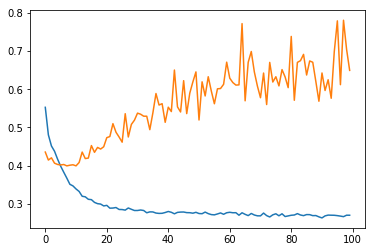

In [119]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.plot(history.epoch, history.history['loss'])
ax.plot(history.epoch, history.history['val_loss'])